In [238]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import sys
sys.path.append(r'C:\Users\yuhan\nanospheres\src')
from utils import load_timestreams, get_psd
from get_sphere_charge import peak_func, fit_peak

In [27]:
from cycler import cycler
default_cycler = cycler(color=['#fe9f6d', '#de4968', '#8c2981', '#3b0f70', '#000004'])

params = {'figure.figsize': (7, 3),
          'axes.prop_cycle': default_cycler,
          'axes.titlesize': 14,
          'legend.fontsize': 12,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

#### Noise from detector and the picoscope

In [326]:
detector_dark = r"D:\others\20240614_detector_dark_noise_200mVrange_laseroff\20240614_detector_dark_noise_200mVrange_1.mat"
detector_laseron = r"D:\others\20240614_detector_noise_nosphere_accoupled\20240614_detector_dark_noise_2.mat"
pickup = r"D:\others\20240618_picoscope_pickup_noise\20240618_picoscope_pickup_noise_02.mat"
pickup_openbnc = r"D:\others\20240618_picoscope_pickup_openbnc\20240618_picoscope_pickup_openbnc_03.mat"

dt0, tt0, nn0 = load_timestreams(detector_dark)
dt1, tt1, nn1 = load_timestreams(detector_laseron)
dt2, tt2, nn2 = load_timestreams(pickup)
dt3, tt3, nn3 = load_timestreams(pickup_openbnc)

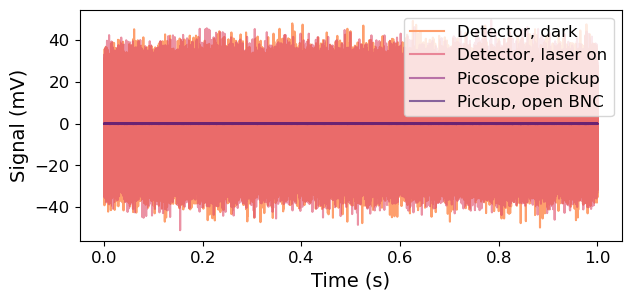

In [327]:
plt.plot(tt0[tt0<1], nn0[0][tt0<1]*1000, label='Detector, dark')
plt.plot(tt1[tt1<1], nn1[0][tt1<1]*1000, label='Detector, laser on', alpha=0.6)
plt.plot(tt2, nn2[0]*1000, label='Picoscope pickup', alpha=0.6)
plt.plot(tt3, nn3[0]*1000, label='Pickup, open BNC', alpha=0.6)

plt.xlabel('Time (s)')
plt.ylabel('Signal (mV)')
plt.legend(loc='upper right')

#### Measured sphere signal at $5.4 \times 10^{-8}$ mbar and 1 mbar

In [328]:
data_dir = r"D:\calibration"
prefix = r'20240617_noefield_5_4e-8mbar'
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

# Join 10 seconds of data together
dt = 0
zz_list = []
for f in file_list:
    dtt, tt, zz = load_timestreams(f)
    zz_list.append(zz[0])
    dt = dtt
zz_timestream = np.concatenate(zz_list)

In [329]:
data_dir = r"D:\calibration"
prefix = r'20240617_1e_50vp2p_89khz_5_4e-8mbar'
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

# Join 10 seconds of data together
dt_driven = 0
zz_list = []
for f in file_list:
    dtt_driven, tt_driven, zz_driven = load_timestreams(f)
    zz_list.append(zz[0])
    dt_driven = dtt_driven
zz_timestream_driven = np.concatenate(zz_list)

In [330]:
data_dir = r"D:\calibration"
prefix = r"20240616_charge_calibration_1mbar\20240616_nodrive"
file_list = glob.glob(f"{data_dir}\{prefix}\*.mat")

dt_1mbar = 0
zz_list = []
for f in file_list:
    dtt_1mbar, tt, zz = load_timestreams(f)
    zz_list.append(zz[0])
    dt_1mbar = dtt
zz_timestream_1mbar = np.concatenate(zz_list)

In [331]:
ff0, pp0 = get_psd(dt0, None, nn0[0])
ff1, pp1 = get_psd(dt1, None, nn1[0])
ff2, pp2 = get_psd(dt2, None, nn2[0])
ff3, pp3 = get_psd(dt3, None, nn3[0])

ff, pp = get_psd(dt, None, zz_timestream)
ff_driven, pp_driven = get_psd(dt_driven, None, zz_timestream_driven)
ff_1mbar, pp_1mbar = get_psd(dt_1mbar, None, zz_timestream_1mbar)

In [88]:
adc_err = 400e-3/(2**12)
adc_pp = adc_err**2 / 1e6  # Assume 1 MHz bandwidth and white

adc_err_pm2v = 4/(2**12)
adc_pp_pm2v = adc_err_pm2v**2 / 1e6  # Assume 1 MHz bandwidth and white

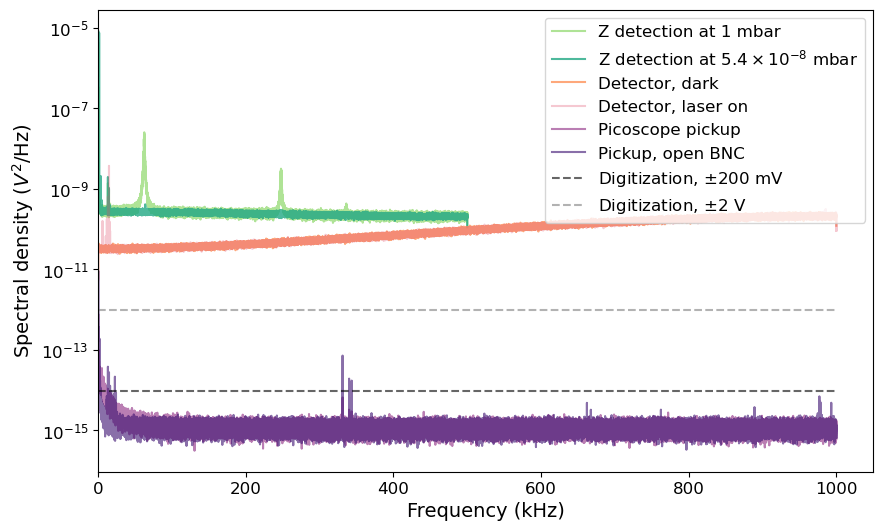

In [104]:
plt.figure(figsize=(10, 6))

plt.plot(ff_1mbar/1000, pp_1mbar, label=r'Z detection at 1 mbar', color='#7ad151', alpha=0.6)
plt.plot(ff/1000, pp, label=r'Z detection at $5.4 \times 10^{-8}$ mbar', color='#22a884', alpha=0.8)
plt.plot(ff0/1000, pp0, label='Detector, dark', alpha=0.9)
plt.plot(ff1/1000, pp1, label='Detector, laser on', alpha=0.3)
plt.plot(ff2/1000, pp2, label='Picoscope pickup', alpha=0.6)
plt.plot(ff3/1000, pp3, label='Pickup, open BNC', alpha=0.6)
plt.plot(np.arange(1000), np.full(1000, adc_pp), 'k--', label=r'Digitization, $\pm 200$ mV', alpha=0.6)
plt.plot(np.arange(1000), np.full(1000, adc_pp_pm2v), '--', color='grey', label=r'Digitization, $\pm 2$ V', alpha=0.6)

plt.xlim(0)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density ($V^2$/Hz)')
plt.yscale('log')
plt.legend(loc='upper right')

#### Estimate power scattered by the sphere

First figure out the total scattered power at the trap focus. Use Equation (2.10b) in Vijay Jain's thesis
$$
    \Omega_z = \frac{24}{\pi c \rho} (\frac{\epsilon - 1}{\epsilon +2}) (\frac{\pi \mathrm{NA}}{\lambda})^4   
    \mathrm{NA}^2 P_0,
$$
where $\rho = 2200$ kg/m$^3$, $\epsilon = (1.45)^2$.
Also assume the Rayleigh range for a strongly focus beam is 2.6 times larger (this is the case for NA=0.8 but NA=0.77 should be similar) so scale $\Omega_z \rightarrow \Omega_z / (2.6)^2$.

In [339]:
hbar = 1.055e-34 # (J / Hz) = (kg * m^2 / s)
c = 3e8
rho = 2000
epsilon = 1.45**2
na = 0.77
lambd = 1064e-9
k = 2 * np.pi / lambd
omega_rayleigh= 2.6 * lambd / (np.pi * na**2)  # 2.6 is a correction to paraxial

p0 = 140e-3
omegaz = np.sqrt(24/(np.pi * c * rho) * (epsilon-1)/(epsilon+2) * (np.pi * na / lambd)**4 * na**2 * p0) / (2.6**2)

In [340]:
print(fr'Power at focus = {p0*1000} mW, predicted z frequency : (2 pi) {omegaz / 2 / np.pi / 1000:.2f} kHz')

Power at focus = 140.0 mW, predicted z frequency : (2 pi) 64.86 kHz


Power scattered by the sphere is given by Eq. (2.24)
$$
    P_{\mathrm{sca}} = \frac{1}{3} \frac{k^4 \alpha^2_0}{\pi^2 \epsilon^2_0} \cdot \frac{1}{\omega^2_0} P_0,
$$
where $\alpha_0 = 3 \epsilon_0 V (\epsilon - 1)/(\epsilon + 2)$ is the polarizability ($V$ is the volume of the sphere). 

In [341]:
v = (4/3) * np.pi * (166e-9/2)**3
p_sca = (1/3) * (k**4 * v**2 * ((epsilon-1)/(epsilon+2))**2 / (np.pi**2)) / (omega_rayleigh**2) * p0
print(f'Power scattered by the sphere = {p_sca * 1e6:2f} uW')

Power scattered by the sphere = 1.079937 uW


#### Bacaction noise

In [342]:
def calc_geometric_factor(na):
    thetamax = np.arcsin(na)
    C = 2 * ( 8 / 15 - (np.cos(thetamax)**(3/2) ) / 3 - (np.cos(thetamax)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax)**(5/2) ) / 5 - (np.cos(thetamax)**(7/2) ) / 7 )
    return D / C

Need to include a gemoetric factor that's relevant for z

In [343]:
A = calc_geometric_factor(na)
S_ff_z_ba = (A**2 + 2/5) * (hbar * k / c) * p_sca       # Backaction force spectrum
S_f_z_ba = 2 * S_ff_z_ba

print(f'Estimated (single sided) backaction force noise: {S_f_z_ba:.2e} N^2/Hz')

Estimated (single sided) backaction force noise: 4.90e-42 N^2/Hz


#### Imprecision noise

In [344]:
S_zz_imp_perfect = (1 / (2/5 + A**2)) * (hbar * c / (4 * k)) / p_sca  # Imprecision assume no information loss
print(f'Estimated (double sided) imprecision noise: {S_zz_imp_perfect:.2e} m^2/Hz assume no information loss')

Estimated (double sided) imprecision noise: 1.14e-27 m^2/Hz assume no information loss


Now estimate the information collection efficiency for NA=0.5 forward scattering lens then attenuated by a factor of 0.0014.

In [345]:
def get_imprecision_forward_z(p_sca, na_tl, na_cl):
    thetamax_tl = np.arcsin(na_tl)
    thetamax_cl = np.arcsin(na_cl)
    
    A = calc_geometric_factor(na_tl)  # Geometrical factor for z
    C = 2 * ( 8 / 15 - (np.cos(thetamax_cl)**(3/2) ) / 3 - (np.cos(thetamax_cl)**(5/2) ) / 5 )
    D = 2 * ( 12 / 35 - (np.cos(thetamax_cl)**(5/2) ) / 5 - (np.cos(thetamax_cl)**(7/2) ) / 7 )
    B_fw_z = (np.pi / 4) * (D - A * C)

    # Use Eq. (D8)  of PRA 100, 04821 (2019)
    s_zz_imp = (hbar*c / (k * p_sca)) * (np.pi * na**2 / (48 * B_fw_z**2))
    return s_zz_imp

In [346]:
nas = np.linspace(0.1, 0.77, 100)
imp_z_forward = np.empty(nas.size)

for i, na in enumerate(nas):
    imp_z_forward[i] = get_imprecision_forward_z(p_sca, 0.77, na)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_16912\1378138815.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  s_zz_imp = (hbar*c / (k * p_sca)) * (np.pi * na**2 / (48 * B_fw_z**2))


Text(0, 0.5, '$\\eta_{z, \\mathrm{forward}}$')

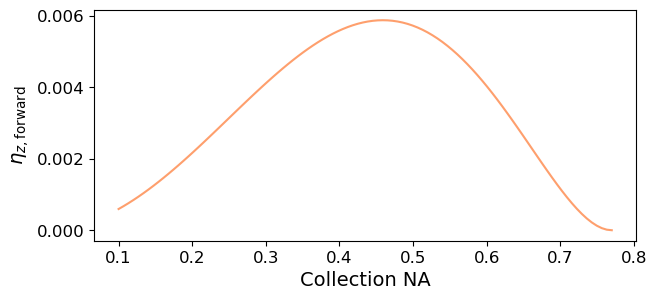

In [347]:
plt.plot(nas, S_zz_imp_perfect/imp_z_forward)
plt.xlabel('Collection NA')
plt.ylabel(r'$\eta_{z, \mathrm{forward}}$')

In [348]:
# Because we only use 0.0014 of the actual scattered photon
# so simply scale by that factor
S_zz_imp_actual = get_imprecision_forward_z(p_sca, na_tl=0.77, na_cl=0.7) / 0.0014
S_z_imp_actual = 2 * S_zz_imp_actual

print(f'Estimated (single sided) imprecision noise: {S_z_imp_actual:.2e} m^2/Hz assume NA=0.5 collection and attenuation by a factor of 0.00014')

Estimated (single sided) imprecision noise: 1.69e-21 m^2/Hz assume NA=0.5 collection and attenuation by a factor of 0.00014


### Calibrate everything into m$^2$/Hz units

Fit a Lorentzian peak to data at $5.4 \times 10^{-8}$ mbar.

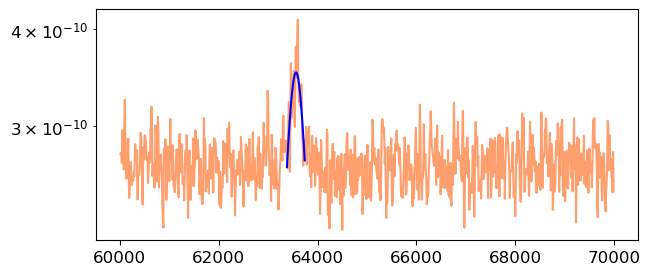

In [336]:
lb, ub = 6338, 6375
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[5000, 63000*2*np.pi, 300])
amp, omega0, gamma = popt[0], popt[1], popt[2]

z_idx = np.logical_and(ff>60000, ff<70000)
plt.plot(ff[z_idx], pp[z_idx])
plt.plot(omega_fit/(2*np.pi), p_fit, 'b')
plt.yscale('log')

In [368]:
m = 2200 * v  # Mass of the sphere in kg

# Make an array of freuqencies
omega = np.linspace(0, 1e6*2*np.pi, 10000)
chi = (1 / m) / (omega0**2 - omega**2 - gamma * omega * 1j) # Complex susceptibility

Electric calibration at low pressure is very noisy. Use calibration factor from thermal calibration at 1 mbar for now...should be accurate within a factor of 2 or so

Calibration factor square $c^2$: 7570665401.040054


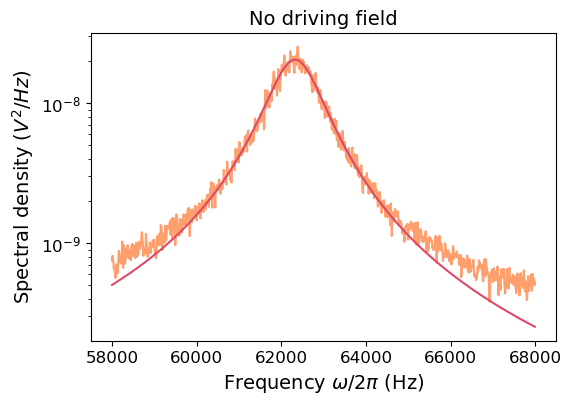

In [357]:
# Fit thermally driven peak to a Lorentzian
lb, ub = 5800, 6800
popt, omega_fit, p_fit = fit_peak(ff_1mbar[lb:ub]*2*np.pi, pp_1mbar[lb:ub], peak_func, p0=[5e7, 64000*2*np.pi, 8000])
amp, omega_1mbar, gamma_1mbar = popt[0], popt[1], popt[2]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff_1mbar[lb:ub], pp_1mbar[lb:ub])
ax.plot(omega_fit/(2*np.pi), p_fit)
ax.set_title('No driving field')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')
ax.set_yscale('log')

# Derive the calibration factor assumed mass and
# thermal equilibrium at 300 K
T   = 300  # K
kb  = 1.38e-23

# Use this value after ethanol is gone
rho = 2000 # kg/m^3
r   = 166e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3

# Again need to take care of 2 pi normalization
# because the formula assume integrating over `omega`, not `f`
v2 = 0.5 * np.pi/(gamma_1mbar * omega_1mbar**2) * amp * gamma_1mbar / (2 * np.pi)

# Calibration factor converting <V^2> to (x^2)
c_cal_square = (v2 * m * omega_1mbar**2) / (kb * T)
print(fr'Calibration factor square $c^2$: {c_cal_square}')

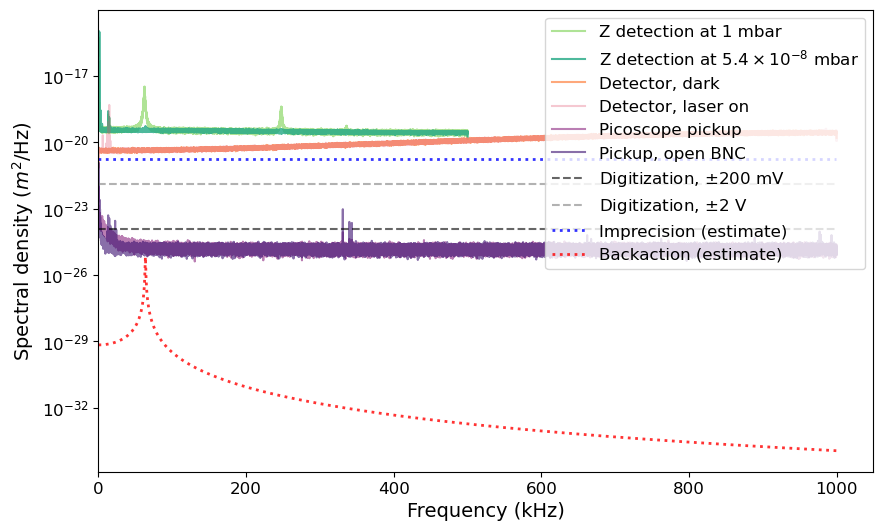

In [370]:
plt.figure(figsize=(10, 6))

plt.plot(ff_1mbar/1000, pp_1mbar/c_cal_square, label=r'Z detection at 1 mbar', color='#7ad151', alpha=0.6)
plt.plot(ff/1000, pp/c_cal_square, label=r'Z detection at $5.4 \times 10^{-8}$ mbar', color='#22a884', alpha=0.8)
plt.plot(ff0/1000, pp0/c_cal_square, label='Detector, dark', alpha=0.9)
plt.plot(ff1/1000, pp1/c_cal_square, label='Detector, laser on', alpha=0.3)
plt.plot(ff2/1000, pp2/c_cal_square, label='Picoscope pickup', alpha=0.6)
plt.plot(ff3/1000, pp3/c_cal_square, label='Pickup, open BNC', alpha=0.6)
plt.plot(np.arange(1000), np.full(1000, adc_pp)/c_cal_square, 'k--', label=r'Digitization, $\pm 200$ mV', alpha=0.6)
plt.plot(np.arange(1000), np.full(1000, adc_pp_pm2v)/c_cal_square, '--', color='grey', label=r'Digitization, $\pm 2$ V', alpha=0.6)

plt.plot(np.arange(1000), np.full(1000, S_z_imp_actual), ':', color='blue', linewidth=2, label=r'Imprecision (estimate)', alpha=0.8)
plt.plot(omega/(1000*2*np.pi), S_f_z_ba*np.abs(chi)**2, ':', color='red', linewidth=2, label=r'Backaction (estimate)', alpha=0.8)


plt.xlim(0)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Spectral density ($m^2$/Hz)')
plt.yscale('log')
plt.legend(loc='upper right')